--------------------------
# Modèle MLP - polarité des labels
- Lucie MASSELIN
--------------------------

## 1. Chargement et échantillonnage
J'ai répéter cette opération sur tous les fichiers des modèles CNN et MLP

In [1]:
import os

FILE_PATH = r'C:\Users\lucie\OneDrive\Documents\SEMESTRE_6\S6C01-test\data\yelp_academic_reviews4students.jsonl'

if os.path.exists(FILE_PATH):
    print(f"Fichier trouvé. Taille : {round(os.path.getsize(FILE_PATH)/1024/1024, 2)} Mo")
else:
    print("ERREUR : Le fichier n'existe pas au chemin indiqué.")
    
# Compter les lignes (1 ligne = 1 avis JSON)
with open(FILE_PATH, "r", encoding="utf-8") as f:
    n_lines = sum(1 for _ in f)

print("Nombre de lignes (avis) :", n_lines)


Fichier trouvé. Taille : 719.56 Mo
Nombre de lignes (avis) : 1000000


In [2]:
import pandas as pd

df_review = pd.read_json(FILE_PATH, lines=True)
df_sample = df_review.sample(n = 50000, random_state = 42)
print(f"Nombre de lignes dans df_sample : {len(df_sample)} avis")

Nombre de lignes dans df_sample : 50000 avis


## 2. Pré traitement

In [3]:
df = df_sample[["review_id", "business_id", "stars", "text"]].copy()
df = df.dropna(subset=["text", "stars"]).reset_index(drop=True)

print("Shape:", df.shape)
df.head(10)

Shape: (50000, 4)


,review_id,business_id,stars,text
0,57Xa8920BrAjNOfqPgFt4Q,_C7QiQQc47AOEv4PE3Kong,1,I'm not quite sure what the hype is all about ...
1,Edkm3QufPBZTxtiWvTjcsQ,MxRZHZoDVVnN7EvMAHf1EA,5,Fleming's for a special occasion or just dinne...
2,HL6_YRk1ZKzfsF_2it7jFg,wu2nJ5lW0tCU3VYa80i8Uw,4,We found this location clean and well-kept. I ...
3,cYp4OouZBSsup6YE1CR73A,u-PhwpLtNmNIjOPo3jTjfw,5,My husband has been coming here for a few year...
4,WzgGRZVVI9HvR-2QCOTtHQ,yK8LWJ4VRTYEoGxVYzcjQg,1,Been here twice since they've opened. Was cert...
5,fyRZd1jVRkrsWs33llCONQ,MOowZBGbgn7FrTol3dvrlg,4,I was pleasantly surprised during our first vi...
6,UgzM4JQOiz-GfAwH3r6OdA,y930pQM0EUblQluRLkXLQg,5,We are very particular about our food . My hus...
7,NJKEs91GuNZVdz6TZTCQWg,IK4iU_hsbzLPbRhZRv1jrw,1,This is a halfway descent motel 6 but there's ...
8,3xU7xswtkPZzN3zSf5fKHg,34Eqv8jXgxg_EEwcsNgeeg,5,We tried looking for some brunch places that w...
9,prYct0PPAkOvUtl3ShDUWw,4r6N_Fhiwoqo_FqQ7Mm6mQ,5,Came back to Tucson to visit family and I'm go...


## 3. Visualisation polarité des labels

In [5]:
import re
from langdetect import detect, LangDetectException

def label_polarity(score):
    if score > 3: return "positif"
    elif score < 3: return "négatif"
    else: return "neutre"

# Fonction pour détecter la langue
def detect_language(text):
    try:
        return detect(text)
    except LangDetectException:
        return "unknown"

print("Détection de la langue en cours (ça peut prendre quelques secondes)")
df['lang'] = df['text'].apply(detect_language)

# Filtrage : On ne garde que l'anglais ('en')
print(f"Avant filtrage : {len(df)} avis")
df = df[df['lang'] == 'en'].reset_index(drop=True)
print(f"Après filtrage (Anglais uniquement) : {len(df)} avis")

def clean_text(text):
    text = str(text).lower()
    text = re.sub(r"http\S+", " ", text)       # enlever liens
    text = re.sub(r"[^a-z\s']", " ", text)     # garder lettres
    text = re.sub(r"\s+", " ", text).strip()   # espaces propres
    return text

print("Nettoyage des textes et création des labels")
df["label"] = df["stars"].apply(label_polarity)
df["text_clean"] = df["text"].astype(str).apply(clean_text)

df[["stars", "label", "text_clean"]].head(10)

Détection de la langue en cours (ça peut prendre quelques secondes)
Avant filtrage : 50000 avis
Après filtrage (Anglais uniquement) : 49947 avis
Nettoyage des textes et création des labels


,stars,label,text_clean
0,1,négatif,i'm not quite sure what the hype is all about ...
1,5,positif,fleming's for a special occasion or just dinne...
2,4,positif,we found this location clean and well kept i o...
3,5,positif,my husband has been coming here for a few year...
4,1,négatif,been here twice since they've opened was certa...
5,4,positif,i was pleasantly surprised during our first vi...
6,5,positif,we are very particular about our food my husba...
7,1,négatif,this is a halfway descent motel but there's a ...
8,5,positif,we tried looking for some brunch places that w...
9,5,positif,came back to tucson to visit family and i'm go...


## 4. Attribution de la calsse pour l'encodage
Le MLP préfère des chiffres (0, 1, 2) plutôt que "négatif", "neutre"...

In [6]:
from sklearn.preprocessing import LabelEncoder

# Transformer les labels en nombre entier (pour les mettres dans des classes)
le = LabelEncoder()
df["label_encoded"] = le.fit_transform(df["label"])

# On récupère le nombre de classes (ici 3) pour la couche de sortie du réseau
NUM_CLASSES = len(le.classes_)
print("Classes :", dict(zip(le.classes_, le.transform(le.classes_))))

Classes : {'neutre': np.int64(0), 'négatif': np.int64(1), 'positif': np.int64(2)}


## 5. Séparation données Train/Test pour des labels

In [ ]:
from sklearn.model_selection import train_test_split

X = df['text_clean']
y = df['label_encoded']

# Découpage Entraînement / Test
X_train_raw, X_test_raw, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print("Répartition des labels encoder en % :")

rating_pct = df['label_encoded'].value_counts(normalize=True).sort_index()
print(rating_pct.map('{:.4f}'.format))

Répartition des labels encoder en % :
label_encoded
0    0.0962
1    0.2357
2    0.6680
Name: proportion, dtype: object


## 6. Représentation de texte + Comparaison

### Représentation du texte TF-IDF (TfidfVectorizer)

In [8]:
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score
from sklearn.feature_extraction.text import TfidfVectorizer


MAX_FEATURES = 20000

print("Vectorisation TF-IDF en cours")
tfidf = TfidfVectorizer(max_features=MAX_FEATURES)
X_train_tfidf = tfidf.fit_transform(X_train_raw).toarray()
X_test_tfidf = tfidf.transform(X_test_raw).toarray()

print(f"Dimension Entrée (Input Shape) : {X_train_tfidf.shape}")


model_tfidf = MLPClassifier(hidden_layer_sizes=(100,), max_iter=1000, early_stopping=True, verbose=False)
model_tfidf.fit(X_train_tfidf, y_train)

predictions_tfidf = model_tfidf.predict(X_test_tfidf)
acc_tfidf = accuracy_score(y_test, predictions_tfidf)

print(f"Précision TF-IDF : {acc_tfidf:.4f}")

Vectorisation TF-IDF en cours
Dimension Entrée (Input Shape) : (39957, 20000)
Précision TF-IDF : 0.8717


### Représentation du texte Sac de mots (BoW) - Bag of Word

In [9]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.neural_network import MLPClassifier

print("\n--- Vectorisation Bag of Words (BoW) en cours ---")

bow_vec = CountVectorizer(max_features=MAX_FEATURES)

X_train_bow_sparse = bow_vec.fit_transform(X_train_raw) 
X_test_bow_sparse = bow_vec.transform(X_test_raw)

X_train_bow = X_train_bow_sparse.toarray() # pas assez de stockage RAM
X_test_bow = X_test_bow_sparse.toarray()

print("Entraînement MLP avec BoW")
model_bow = MLPClassifier(hidden_layer_sizes=(100,), max_iter=1000, early_stopping=True, verbose=True)
model_bow.fit(X_train_bow, y_train)

predictions_bow = model_bow.predict(X_test_bow)
acc_bow = accuracy_score(y_test, predictions_bow)

print(f"Précision BoW : {acc_bow:.4f}")


--- Vectorisation Bag of Words (BoW) en cours ---
Entraînement MLP avec BoW
Iteration 1, loss = 0.46405551
Validation score: 0.863864
Iteration 2, loss = 0.27200786
Validation score: 0.862863
Iteration 3, loss = 0.19061375
Validation score: 0.864114
Iteration 4, loss = 0.12899981
Validation score: 0.860611
Iteration 5, loss = 0.08194465
Validation score: 0.853854
Iteration 6, loss = 0.05009768
Validation score: 0.852352
Iteration 7, loss = 0.03066309
Validation score: 0.845345
Iteration 8, loss = 0.01871705
Validation score: 0.846597
Iteration 9, loss = 0.01216228
Validation score: 0.844344
Iteration 10, loss = 0.00855742
Validation score: 0.843343
Iteration 11, loss = 0.00630092
Validation score: 0.843594
Iteration 12, loss = 0.00487246
Validation score: 0.842342
Iteration 13, loss = 0.00393049
Validation score: 0.844595
Iteration 14, loss = 0.00325161
Validation score: 0.844094
Validation score did not improve more than tol=0.000100 for 10 consecutive epochs. Stopping.
Précision BoW

### Représentation du texte BM25 (Best Matching 25)

In [ ]:
from sklearn.base import BaseEstimator, TransformerMixin
import numpy as np
from sklearn.metrics import accuracy_score


class BM25Transformer(BaseEstimator, TransformerMixin):
    def __init__(self, k1=1.5, b=0.75):
        self.k1 = k1
        self.b = b

    def fit(self, X):
        # Calcul de la longueur moyenne des documents (avgdl)
        self.doc_len_ = np.sum(X, axis=1)
        self.avgdl_ = np.mean(self.doc_len_)
        N = X.shape[0] # Calcul de l'IDF pour chaque mot
        n_q = np.diff(X.tocsc().indptr) # Nombre de documents contenant chaque mot
        # Formule IDF standard du BM25
        self.idf_ = np.log((N - n_q + 0.5) / (n_q + 0.5) + 1)
        return self

    def transform(self, X):
        X = X.tocoo() # Conversion format sparse pour itérer
        n_features = X.shape[1]
        doc_len = np.array(X.sum(axis=1)).flatten() # Etendre la matrice en vecteur de longueurs de documents
        # Calcul du numérateur et dénominateur BM25
        data = X.data
        rows = X.row
        cols = X.col
        numerator = data * (self.k1 + 1)
        denominator = data + self.k1 * (1 - self.b + self.b * (doc_len[rows] / self.avgdl_))
        # Multiplication par IDF
        bm25_data = self.idf_[cols] * (numerator / denominator)
        # Reconstitution de la matrice (en Dense pour le MLP)
        from scipy.sparse import coo_matrix
        return coo_matrix((bm25_data, (rows, cols)), shape=X.shape).toarray()
    

print("\n--- Entraînement avec BM25 (20000 mots) ---")

bm25 = BM25Transformer() # Pour BM25, on part des comptes du BoW et on transforme
bm25.fit(X_train_bow_sparse) # On fit sur le train (calcul des stats de corpus)

X_train_bm25 = bm25.transform(X_train_bow_sparse)
X_test_bm25 = bm25.transform(X_test_bow_sparse)

model_bm25 = MLPClassifier(hidden_layer_sizes=(100,), max_iter=1000, early_stopping=True)
model_bm25.fit(X_train_bm25, y_train)
acc_bm25 = accuracy_score(y_test, model_bm25.predict(X_test_bm25))
print(f"Précision BM25 : {acc_bm25:.4f}")


--- Entraînement avec BM25 (20000 mots) ---
Précision BM25 : 0.8642


### Comparaison TF-IDF, Sac de Mot et BM25

In [25]:
import pandas as pd

print("\n--- Comparaison TF-IDF, Sac de Mots et BM25 ---")

# On regroupe tout dans une liste pour faciliter le tri
performances = [
    {"name": "TF-IDF", "acc": acc_tfidf, "model_mlp": model_tfidf, "features": MAX_FEATURES}, # MAX_FEATURES
    {"name": "Sac de Mots (BoW)", "acc": acc_bow, "model_mlp": model_bow, "features": MAX_FEATURES},
    {"name": "BM25", "acc": acc_bm25, "model_mlp": model_bm25, "features": MAX_FEATURES}
]

# On trie du meilleur au moins bon (reverse=True)
performances.sort(key=lambda x: x['acc'], reverse=True)

# On récupère le gagnant et le deuxième
best = performances[0]
second = performances[1]
best_model = best['model_mlp']

ecart = best['acc'] - second['acc']

# Affichage du verdict
print(f"Meilleure représentation de texte : {best['name']}")
print(f"Avec une précision de : {best['acc']:.4f})")

if ecart > 0:
    print(f"Il bat le deuxième ({second['name']}) de {ecart:.4f}")
else:
    print("Ex aequo parfait avec le deuxième !")

# Tableau récapitulatif avec Pandas
results = pd.DataFrame({
    "Méthode": [p['name'] for p in performances], # L'ordre suivra le classement
    "Nombre Features": [p['features'] for p in performances],
    "Précision": [p['acc'] for p in performances]
})

print("\n" + "="*40)
print(results.to_string(index=False))


--- Comparaison TF-IDF, Sac de Mots et BM25 ---
Meilleure représentation de texte : TF-IDF
Avec une précision de : 0.8717)
Il bat le deuxième (BM25) de 0.0075

          Méthode  Nombre Features  Précision
           TF-IDF            20000   0.871672
             BM25            20000   0.864164
Sac de Mots (BoW)            20000   0.863664


## 7. Modèle MLP de l'apprentissage Deep Learning

In [12]:
from sklearn.metrics import accuracy_score
import tensorflow as tf


# Modele MLP avec keras
print("Construction du modèle Keras")

model_mlp = tf.keras.Sequential([
    # Couche d'entrée : elle doit faire la taille du vocabulaire TF-IDF (5000)
    tf.keras.layers.Input(shape=(MAX_FEATURES,)),
    
    # Couche Cachée 1 (128 neurones)
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    
    # Couche Cachée 2 (64 neurones)
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dropout(0.3),
    
    # Couche de Sortie (3 neurones car 3 classes : neg, neu, pos)
    # Softmax = probabilités
    tf.keras.layers.Dense(NUM_CLASSES, activation='softmax')
])

print("Modèle MLP Keras construit")


Construction du modèle Keras
Modèle MLP Keras construit


In [13]:
# Compilation
model_mlp.compile(
    loss="sparse_categorical_crossentropy", # 'sparse' car nos labels sont des entiers (0, 1, 2)
    optimizer="adam",
    metrics=["accuracy"]
)

model_mlp.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 128)            │     2,560,128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 3)              │           195 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,568,579 (9.80 MB)

 Trainable params: 2,568,579 (9.80 MB)

 Non-trainable params: 0 (0.00 B)

In [14]:
from sklearn.utils import class_weight

# Calcul des poids (Class Weights)
classes = np.unique(y_train) # Trouve [0, 1, 2]
weights = class_weight.compute_class_weight(
    class_weight='balanced', 
    classes=classes, 
    y=y_train
)
class_weight_dict = dict(zip(classes, weights))

print("Poids des classes :", class_weight_dict)

Poids des classes : {np.int64(0): np.float64(3.4460543337645535), np.int64(1): np.float64(1.394805738820819), np.int64(2): np.float64(0.5017895490336435)}


In [ ]:
early_stop = tf.keras.callbacks.EarlyStopping(
    monitor="val_loss", 
    patience=3,
    restore_best_weights=True
)

history = model_mlp.fit(
    X_train_tfidf, y_train,
    validation_data=(X_test_tfidf, y_test), # On valide sur le test pour voir la progression
    epochs=15,
    batch_size=32,
    callbacks=[early_stop],
    class_weight=class_weight_dict,   # On injecte les poids calculés
    verbose=1
)

Epoch 1/15
1249/1249 ━━━━━━━━━━━━━━━━━━━━ 26s 20ms/step - accuracy: 0.7648 - loss: 0.6529 - val_accuracy: 0.7933 - val_loss: 0.4920
Epoch 2/15
1249/1249 ━━━━━━━━━━━━━━━━━━━━ 22s 18ms/step - accuracy: 0.8457 - loss: 0.4329 - val_accuracy: 0.8175 - val_loss: 0.4661
Epoch 3/15
1249/1249 ━━━━━━━━━━━━━━━━━━━━ 22s 17ms/step - accuracy: 0.8942 - loss: 0.3006 - val_accuracy: 0.8163 - val_loss: 0.5211
Epoch 4/15
1249/1249 ━━━━━━━━━━━━━━━━━━━━ 22s 18ms/step - accuracy: 0.9334 - loss: 0.1940 - val_accuracy: 0.8293 - val_loss: 0.5080
Epoch 5/15
1249/1249 ━━━━━━━━━━━━━━━━━━━━ 21s 17ms/step - accuracy: 0.9578 - loss: 0.1304 - val_accuracy: 0.8268 - val_loss: 0.6041


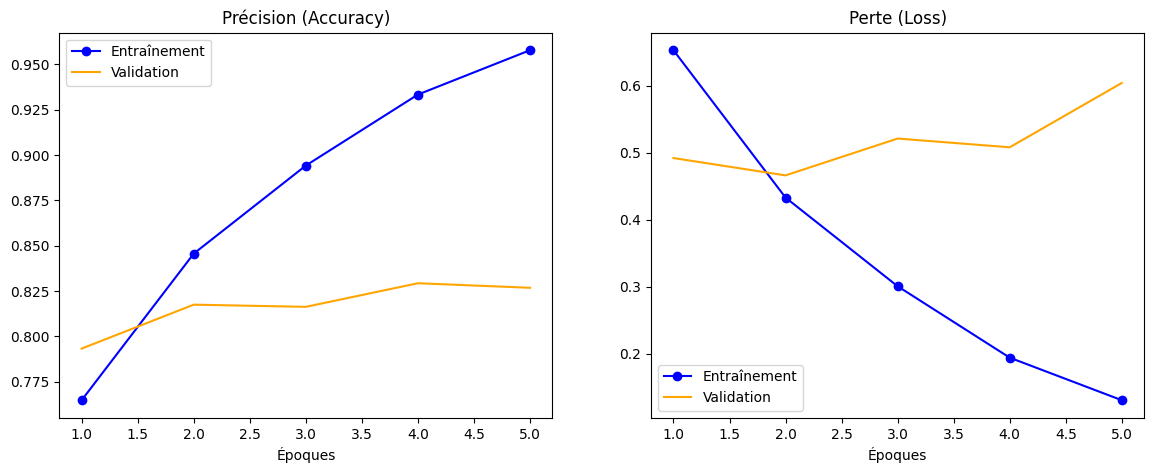

In [16]:
import matplotlib.pyplot as plt

# Graphiques de l'historique (Loss & Accuracy)
def plot_learning_curves(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs = range(1, len(acc) + 1)

    plt.figure(figsize=(14, 5))

    # Précision
    plt.subplot(1, 2, 1)
    plt.plot(epochs, acc, 'bo-', label='Entraînement')
    plt.plot(epochs, val_acc, 'orange', label='Validation')
    plt.title('Précision (Accuracy)')
    plt.xlabel('Époques')
    plt.legend()

    # Perte (Loss)
    plt.subplot(1, 2, 2)
    plt.plot(epochs, loss, 'bo-', label='Entraînement')
    plt.plot(epochs, val_loss, 'orange', label='Validation')
    plt.title('Perte (Loss)')
    plt.xlabel('Époques')
    plt.legend()

    plt.show()

plot_learning_curves(history)


--- Evaluation Finale ---


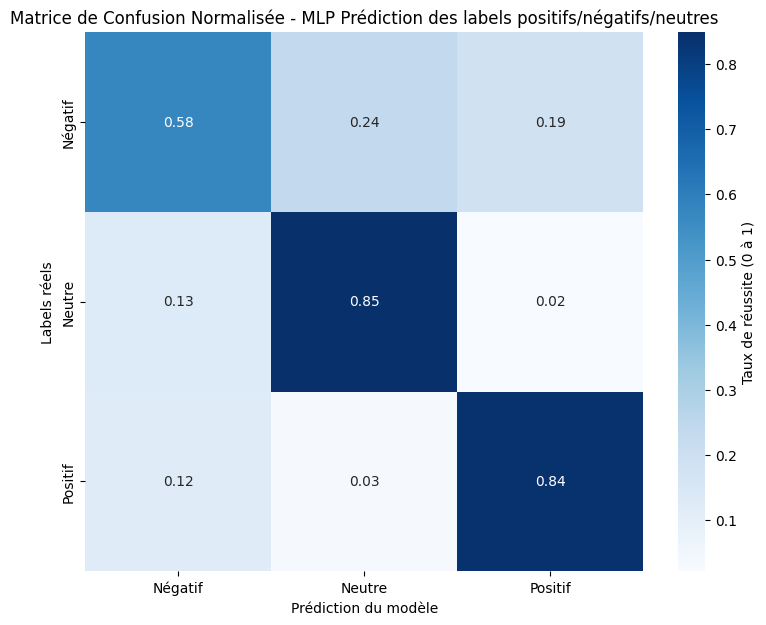

Précision (Accuracy) : 0.8175
F1-Score (Ajusté)    : 0.8359
Perte (Log Loss)     : 0.4661

Rapport détaillé :
              precision    recall  f1-score   support

      neutre       0.32      0.58      0.41       941
     négatif       0.80      0.85      0.83      2226
     positif       0.96      0.84      0.90      6823

    accuracy                           0.82      9990
   macro avg       0.70      0.76      0.71      9990
weighted avg       0.87      0.82      0.84      9990



In [17]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report, f1_score, log_loss

# Graphique de matrice de confusion
print("\n--- Evaluation Finale ---")

# Prédictions (ce sont des probabilités)
y_pred_probs = model_mlp.predict(X_test_tfidf, verbose=0)
y_pred = np.argmax(y_pred_probs, axis=1)

# Création de la matrice
cm = confusion_matrix(y_test, y_pred)
cm_norm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

acc_mlp = accuracy_score(y_test, y_pred)
f1_mlp = f1_score(y_test, y_pred, average='weighted')
loss_mlp = log_loss(y_test, y_pred_probs)

# Affichage avec Seaborn
plt.figure(figsize=(9, 7))
sns.heatmap(cm_norm, 
            annot=True, 
            fmt='.2f',
            cmap='Blues',
            xticklabels=['Négatif', 'Neutre', 'Positif'],
            yticklabels=['Négatif', 'Neutre', 'Positif'],
            cbar_kws={'label': 'Taux de réussite (0 à 1)'})

plt.title('Matrice de Confusion Normalisée - MLP Prédiction des labels positifs/négatifs/neutres')
plt.xlabel('Prédiction du modèle')
plt.ylabel('Labels réels')
plt.show()

print(f"Précision (Accuracy) : {acc_mlp:.4f}")
print(f"F1-Score (Ajusté)    : {f1_mlp:.4f}")
print(f"Perte (Log Loss)     : {loss_mlp:.4f}")

print("\nRapport détaillé :")
print(classification_report(y_test, y_pred, target_names=le.classes_))

## 8. Sauvegarder modèle, TF-IDF et LabelEncoder pour les tests 

In [26]:
import pickle

# Sauvegarde du modèle Keras
model_mlp.save('model_polarite.keras')

# Sauvegarde du TF-IDF et du LabelEncoder
with open('tfidf_polarite.pkl', 'wb') as f:
    pickle.dump(tfidf, f)
    
with open('label_encoder_polarite.pkl', 'wb') as f:
    pickle.dump(le, f)

print("Sauvegardes du modèle de polarité terminées.")

Sauvegardes du modèle de polarité terminées.
